## Importing the relevant libraries

In [1]:
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, LSTM, Embedding, Input, TimeDistributed, Concatenate, Attention
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, re
warnings.filterwarnings('ignore')
import tensorflow as tf
from tqdm.notebook import tqdm
tqdm.pandas()
from tensorflow.keras import backend as K
logger = tf.get_logger()
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

2024-03-23 00:01:05.257992: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-23 00:01:05.258091: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-23 00:01:05.385974: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Loading the dataset

In [2]:
df = pd.read_csv('/kaggle/input/global-news-dataset/data.csv',nrows=80000)
df = df[['description','title']]
df.head()

,description,title
0,UN Secretary-General Antonio Guterres urged th...,UN Chief Urges World To 'Stop The Madness' Of ...
1,[株式会社Ainer]\nRANDEBOO（ランデブー）では2023年7月18日(火)より公...,RANDEBOOよりワンランク上の大人っぽさが漂うニットとベストが新登場。
2,UN Secretary-General Antonio Guterres urged th...,UN Chief Urges World to 'Stop the Madness' of ...
3,Ecologists caution against the adverse effects...,Sikkim warning: Hydroelectricity push must be ...
4,"France lost 35 citizens, Thailand 33, US 31, U...","200 foreigners, dual nationals cut down in Ham..."


## Data Exploration

In [3]:
df.shape

(80000, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  79623 non-null  object
 1   title        79960 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [5]:
df.isna().sum()

description    377
title           40
dtype: int64

In [6]:
df = df.dropna()
df.shape

(79606, 2)

In [7]:
df.duplicated().sum()

4314

In [8]:
df = df.drop_duplicates()
df.shape

(75292, 2)

In [9]:
df.rename({'description': 'text','title': 'summary'},axis=1,inplace=True)

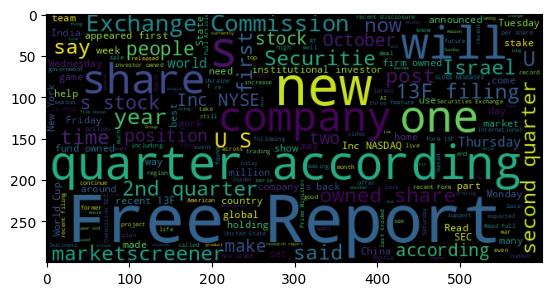

In [10]:
wc = WordCloud(width=600,height=300).generate(' '.join(df.text))
plt.imshow(wc);

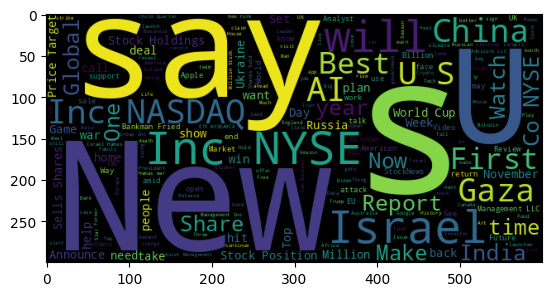

In [11]:
wc = WordCloud(width=600,height=300).generate(' '.join(df.summary))
plt.imshow(wc);

In [12]:
df.summary = df.summary.apply(lambda x: '<start> ' + x + ' <end>')

In [13]:
df['text_len'] = df['text'].apply(len)
df['summary_len'] = df['summary'].apply(len)

<Axes: xlabel='summary_len', ylabel='Density'>

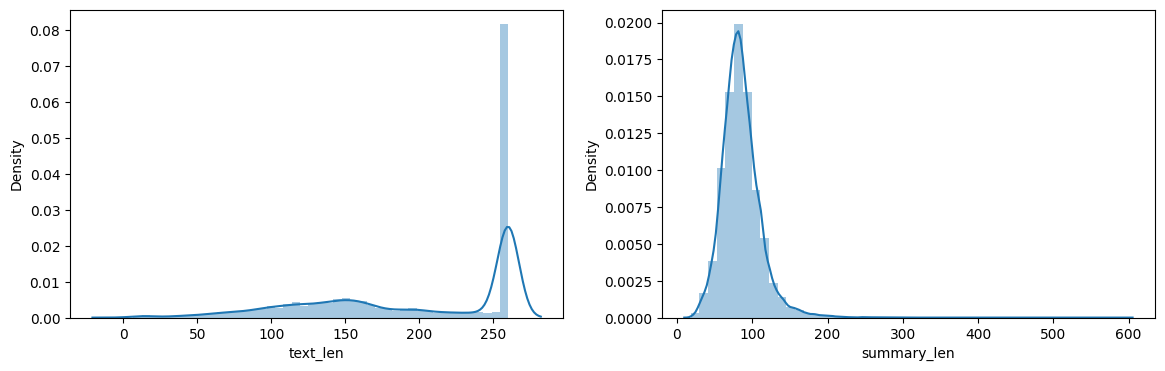

In [14]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(14,4))
sns.distplot(df['text_len'],ax=axes[0])
sns.distplot(df['summary_len'],ax=axes[1])

In [15]:
df.describe()

,text_len,summary_len
count,75292.000000,75292.000000
mean,197.068082,85.226917
std,69.133592,26.221074
min,1.000000,18.000000
25%,139.000000,69.000000
50%,225.000000,83.000000
75%,260.000000,98.000000
max,260.000000,597.000000


In [16]:
max_text_len = 190
max_summary_len = 80

In [17]:
for i in np.arange(0.9,1.0,0.01):
    print(f"{i} percentile value of text length is ",df['text_len'].quantile(i))
    print(f"{i} percentile value of summary length is ",df['summary_len'].quantile(i))

0.9 percentile value of text length is  260.0
0.9 percentile value of summary length is  115.0
0.91 percentile value of text length is  260.0
0.91 percentile value of summary length is  117.0
0.92 percentile value of text length is  260.0
0.92 percentile value of summary length is  119.0
0.93 percentile value of text length is  260.0
0.93 percentile value of summary length is  122.0
0.9400000000000001 percentile value of text length is  260.0
0.9400000000000001 percentile value of summary length is  125.0
0.9500000000000001 percentile value of text length is  260.0
0.9500000000000001 percentile value of summary length is  129.0
0.9600000000000001 percentile value of text length is  260.0
0.9600000000000001 percentile value of summary length is  134.0
0.9700000000000001 percentile value of text length is  260.0
0.9700000000000001 percentile value of summary length is  140.0
0.9800000000000001 percentile value of text length is  260.0
0.9800000000000001 percentile value of summary length

## Text Tokenization

In [18]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(df.text)

In [19]:
text_vocab_length = len(x_tokenizer.index_word) + 1
text_vocab_length

114817

In [20]:
text_sequences = x_tokenizer.texts_to_sequences(df.text)
text_pad_sequences = pad_sequences(text_sequences,maxlen=max_text_len,padding='post')

In [21]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(df.summary)

In [22]:
summary_vocab_length = len(y_tokenizer.index_word) + 1
summary_vocab_length

72312

In [23]:
summary_sequences = y_tokenizer.texts_to_sequences(df.summary)
summary_pad_sequences = pad_sequences(summary_sequences,maxlen=max_summary_len,padding='post')

## Splitting the padded sequences data into train and test sets

In [24]:
X_train, X_test, y_train, y_test = train_test_split(text_pad_sequences,summary_pad_sequences,test_size=0.25,shuffle=True,random_state=101)

## Model Architecture

In [25]:
class LuongAttention(tf.keras.layers.Layer):
  def _init_(self, units):
    super(LuongAttention, self)._init_()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    print('\n*** Luong Attention  STARTS****')
    print('query (decoder hidden state): (batch_size, hidden size) ', query.shape)
    print('values (encoder all hidden state): (batch_size, max_len, hidden size) ', values.shape)

    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)
    
    print('query_with_time_axis:(batch_size, 1, hidden size) ', query_with_time_axis.shape)


    values_transposed = tf.transpose(values, perm=[0, 2, 1])
    print('values_transposed:(batch_size, hidden size, max_len) ', values_transposed.shape)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    #BAHDANAU ADDITIVE:
    #score = self.V(tf.nn.tanh(
    #    self.W1(query_with_time_axis) + self.W2(values)))
    
    #LUONGH Dot-product
    score = tf.transpose(tf.matmul(query_with_time_axis, values_transposed) , perm=[0, 2, 1])

    print('score: (batch_size, max_length, 1) ',score.shape)
    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)
    print('attention_weights: (batch_size, max_length, 1) ',attention_weights.shape)
    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    print('context_vector before reduce_sum: (batch_size, max_length, hidden_size) ',context_vector.shape)
    context_vector = tf.reduce_sum(context_vector, axis=1)
    print('context_vector after reduce_sum: (batch_size, hidden_size) ',context_vector.shape)


    print('\n*** Luong Attention ENDS****')
    return context_vector, attention_weights

In [26]:
K.clear_session()

latent_dim = 2
embedding_dim = 100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

# Encoder Embedding Layer
enc_emb =  Embedding(text_vocab_length, embedding_dim,trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(max_summary_len,))

# Decoder Embedding Layer
dec_emb_layer = Embedding(summary_vocab_length, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM Layer
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention Layer
attention_layer = Attention()
attention_output = attention_layer([decoder_outputs, encoder_outputs])

# Concatenate attention output and decoder output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attention_output])

# Dense Layer
decoder_dense = TimeDistributed(Dense(summary_vocab_length, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 190)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 190, 100)  │ 11,481,700 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 190, 2),  │        824 │ embedding[0][0]   │
│                     │ (None, 2), (None, │            │                   │
│                     │ 2)]               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 80)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 190, 2),  │         40 │ lstm[0][0]        │
│                     │ (None, 2), (None, │            │                   │
│                     │ 2)]               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 80, 100)   │  7,231,200 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 190, 2),  │         40 │ lstm_1[0][0]      │
│                     │ (None, 2), (None, │            │                   │
│                     │ 2)]               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 80, 2),   │        824 │ embedding_1[0][0… │
│                     │ (None, 2), (None, │            │ lstm_2[0][1],     │
│                     │ 2)]               │            │ lstm_2[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 80, 2)     │          0 │ lstm_3[0][0],     │
│ (Attention)         │                   │            │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer        │ (None, 80, 4)     │          0 │ lstm_3[0][0],     │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 80, 72312) │    361,560 │ concat_layer[0][… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,076,188 (72.77 MB)

 Trainable params: 19,076,188 (72.77 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.1,weight_decay=0.01,clipnorm=1.0),metrics=['accuracy'])

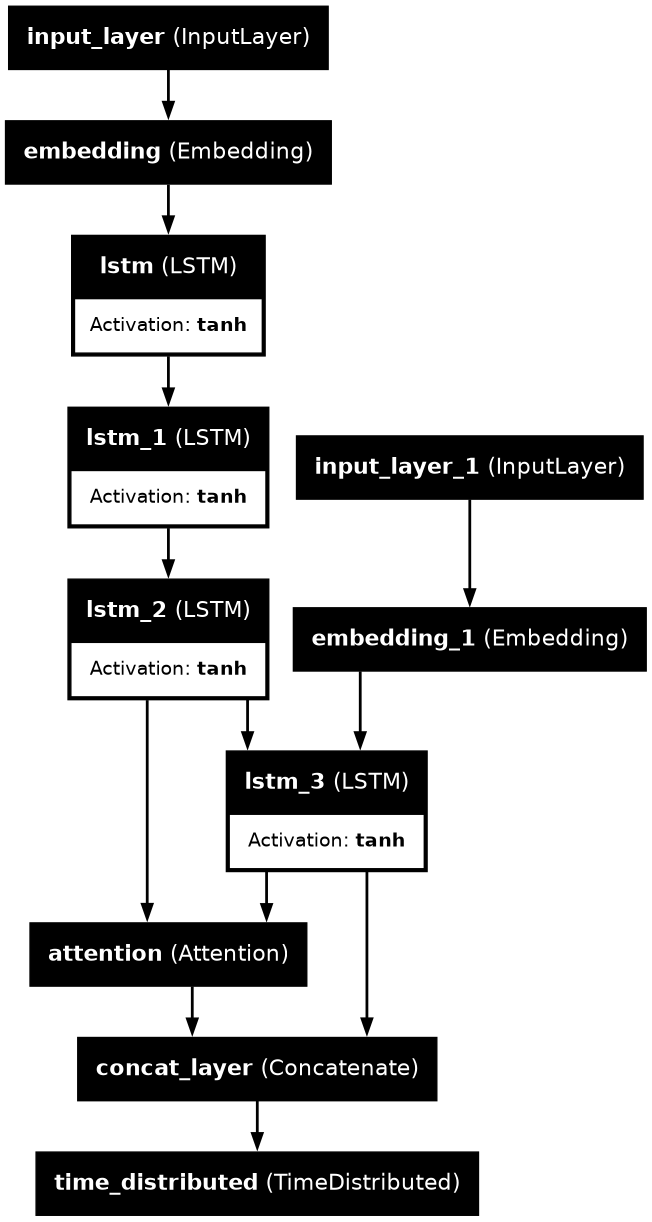

In [28]:
plot_model(model,to_file='model.png',show_layer_activations=True,show_layer_names=True,dpi=100)

In [29]:
def time_based_decay(epoch, lr):
    decay_rate = 0.1
    decay_steps = 5
    return lr * (1 / (1 + decay_rate * epoch / decay_steps))

es = EarlyStopping(monitor='val_accuracy',mode='max',verbose=1,patience=5)
mc = ModelCheckpoint('text_summarizer.keras',monitor='val_accuracy',verbose=1,mode='max',save_best_only=True)
lrs = LearningRateScheduler(time_based_decay,verbose=2)

r = model.fit([X_train,y_train],
             y_train.reshape(y_train.shape[0],y_train.shape[1],1),
             epochs=36,
             batch_size=128,
             callbacks=[es,lrs,mc],
             validation_data = ([X_test,y_test],y_test.reshape(y_test.shape[0],y_test.shape[1],1)))


Epoch 1: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 1/36
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8150 - loss: 2.5240
Epoch 1: val_accuracy improved from -inf to 0.86280, saving model to text_summarizer.keras
442/442 ━━━━━━━━━━━━━━━━━━━━ 650s 1s/step - accuracy: 0.8151 - loss: 2.5217 - val_accuracy: 0.8628 - val_loss: 1.1458 - learning_rate: 0.1000

Epoch 2: LearningRateScheduler setting learning rate to 0.09803921714717266.
Epoch 2/36
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8643 - loss: 1.1186
Epoch 2: val_accuracy improved from 0.86280 to 0.86377, saving model to text_summarizer.keras
442/442 ━━━━━━━━━━━━━━━━━━━━ 634s 1s/step - accuracy: 0.8643 - loss: 1.1186 - val_accuracy: 0.8638 - val_loss: 1.0947 - learning_rate: 0.0980

Epoch 3: LearningRateScheduler setting learning rate to 0.09426847816659853.
Epoch 3/36
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8634 - loss: 1.0898
Epoch 3: val_accuracy did not improve from

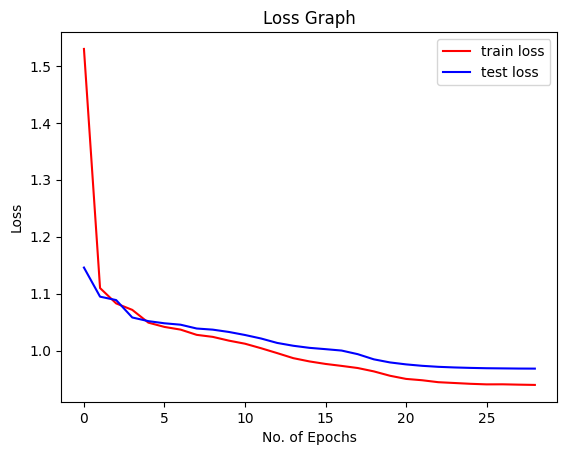

In [30]:
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

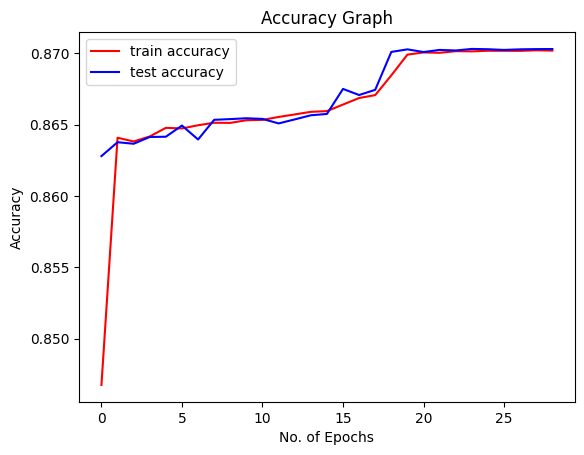

In [31]:
plt.plot(r.history['accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [32]:
loss, acc = model.evaluate([X_test,y_test],y_test.reshape(y_test.shape[0],y_test.shape[1],1))
print(f"Loss: {np.round(loss,2)}")
print(f"Accuracy: {np.round(acc*100,2)}%")

589/589 ━━━━━━━━━━━━━━━━━━━━ 190s 322ms/step - accuracy: 0.8703 - loss: 0.9675
Loss: 0.97
Accuracy: 87.03%


In [33]:
model.save('text_summarizer.keras')

In [34]:
model = load_model('text_summarizer.keras',custom_objects={'Attention': Attention})
model

<Functional name=functional_1, built=True>

In [35]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [36]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder states inputs
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h,decoder_state_input_c]

# Decoder outputs and states
decoder_outputs, state_h, state_c = decoder_lstm(dec_emb,initial_state=decoder_states_inputs)
decoder_states = [state_h,state_c]

# Attention Inference Layer
attention_output_inference = attention_layer([decoder_outputs,encoder_outputs])

# Concatenate attention output and decoder output
decoder_concat_input_inference = Concatenate(axis=-1,name='concat-layer')([decoder_outputs,attention_output_inference])

# Final decoder output
decoder_output_inference = decoder_dense(decoder_concat_input_inference)

# Decoder Model
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                     [decoder_output_inference] + decoder_states)

## Inference process

In [37]:
def decode_sequence(input_seq):
    # Encode the input as state vectors
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    encoder_states = [e_h, e_c]
    # Generate empty target sequence of length 1
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word
    target_seq[0, 0] = target_word_index['start']

    # Sampling loop for a batch of sequences
    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + encoder_states)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if sampled_token != 'end':
            decoded_sentence += ' '+ sampled_token

        # Exit condition: either find stop word or hit max length
        if sampled_token == 'end' or len(decoded_sentence.split()) >= (max_summary_len-1):
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        encoder_states = [h, c]

    return decoded_sentence

In [38]:
def seq2summary(input_seq):
    newString = ''
    
    for i in input_seq:
        if (i != 0 and i != target_word_index['start']) and i != target_word_index['end']:
            newString = newString + reverse_target_word_index[i] + ' '
            
    return newString

def seq2text(input_seq):
    newString = ''
    
    for i in input_seq:
        if i != 0:
            newString=newString+reverse_source_word_index[i]+' '
            
    return newString

In [39]:
# for i in range(0,100):
#     print("Review:",seq2text(X_train[i]))
#     print("Original summary:",seq2summary(y_train[i]))
#     print("Predicted summary:",decode_sequence(X_train[i].reshape(1,max_text_len)))
#     print("\n")